# Previsão de Séries Temporais

Esse exercício objetiva a utilização de Programação Genética para construir um modelo para a previsão de séries temporais. A série temporal em questão refere-se ao ativo PETR4 no período entre 16/05/2018 e 17/04/2019.

O problema é apresentado em mais detalhes [aqui](series-2020.pdf).

## Abordagem 

Apesar da proposta inicial do problema sugerir a utilização de Programação Genética, optou-se por fazer uso de Programação de Expressão Genética para abordar o exercício.

As funções utilizadas foram:

- Módulo
- Inverso
- Multiplicação
- Soma
- Subtração
- Divisão protegida (determinou-se que a divisão por 0 resulta em 0)

O conjunto de terminais usados é composto por todos os indicadores de um determinado instante de tempo (SMA, WMA, MACD, RSI e MOM), e dos indicadores do instante de tempo anterior (no caso da primeira instância, usou-se os mesmos indicadores duas vezes).

O cromossomo é composto por um único gene cuja cabeça (_tail_) tem tamanho 20.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import geppy as gep
from deap import creator, base, tools
from sklearn.metrics import confusion_matrix
import operator
import random
import multiprocessing
#random.seed(42)
#np.random.seed(42)

Define função de divisão protegida.

In [2]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 0
    return x1/x2

Função para avaliar a qualidade de um indivíduo, calculando o fitness. O fitness é obtido por uma soma de todas as predições corretas. Devido ao caráter desbalanceado do dataset, fez-se uso de uma constante (peso) para evitar predições tendenciosas para a classe da maioria.

In [3]:
def evaluate(individual):
    """Evalute the fitness of an individual"""
    n_correct = 0
    
    preds = predict(individual, X_train)
    
    correct = y_train[np.where(preds == y_train)]
    
    n_correct += correct[np.where(correct == 'STABLE')].shape[0]
    n_correct += correct[np.where(correct != 'STABLE')].shape[0] * peso
    
    return (n_correct / total),

Computa todas as predições de _data_ com a função gerada pela expressão do indivíduo.

In [4]:
def predict(individual, data):
    func = toolbox.compile(individual)  # a lambda function
    preds = []
    for i, (sma, wma, macd, rsi, mom) in enumerate(data):
        if i == 0:
            (psma, pwma, pmacd, prsi, pmom) = X_train[i]
        else:
            (psma, pwma, pmacd, prsi, pmom) = X_train[i-1]
            
        prediction = int(func(sma, wma, macd, rsi, mom, psma, pwma, pmacd, prsi, pmom))
        
        if prediction >= 1:
            prediction = 'UP'
        elif prediction <= -1:
            prediction = 'DOWN'
        else:
            prediction = 'STABLE'
            
        preds.append(prediction)
        
    return preds

Plota a matriz de confusão normalizada.

In [5]:
def plot_cm(preds, true):
    labels=['DOWN', 'STABLE', 'UP']
    cm = confusion_matrix(true, preds)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(pd.DataFrame(norm_cm, index=labels, columns=labels), annot=True, cmap='RdBu_r', fmt='.2f')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

Leitura dos dados.

In [6]:
train = pd.read_csv('data/treino.csv')
test = pd.read_csv('data/teste.csv')
train.head()

,datetime,sma,wma,macd,rsi,mom,class
0,2018-05-16 11:37:00,-1,-1,-1,-1,1,STABLE
1,2018-05-16 11:38:00,-1,-1,1,-1,1,STABLE
2,2018-05-16 11:39:00,-1,-1,-1,-1,1,STABLE
3,2018-05-16 11:40:00,1,1,-1,-1,-1,STABLE
4,2018-05-16 11:41:00,1,1,-1,-1,-1,STABLE


In [7]:
X_train = train.loc[:, 'sma':'mom'].to_numpy()
y_train = train.loc[:, 'class'].to_numpy()
X_test = test.loc[:, 'sma':'mom'].to_numpy()
y_test = test.loc[:, 'class'].to_numpy()

_peso_ é a constante pela qual os acertos das classes da minoria são multiplicadas. _total_ é a quantidade de "pontos" necessários para acertar todas as predições.

In [8]:
peso = 4
_, counts = np.unique(train.iloc[:, -1].to_numpy(), return_counts=True)
total = (counts[0] + counts[2]) * peso + counts[1]

Aqui definimos o conjunto de funções e terminais. 

In [9]:
input_names = list(train.columns.values[1:-1])
input_names.extend(['p_' + w for w in input_names])

pset = gep.PrimitiveSet('Main', input_names=input_names)

pset.add_function(operator.abs, 1)
pset.add_function(operator.neg, 1)
pset.add_function(operator.mul, 2)
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(protected_div, 2)

In [10]:
creator.create("FitnessMax", base.Fitness, weights=(1,))  # to maximize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMax)

In [11]:
h = 10   # head length
n_genes = 1   # number of genes in a chromosome
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [12]:
toolbox.register('evaluate', evaluate)

In [13]:
toolbox.register('select', tools.selRoulette)

## general mutations whose aliases start with 'mut'
# We can specify the probability for an operator with the .pbs property
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=2 / (2 * h + 1))
toolbox.pbs['mut_uniform'] = 0.1
# Alternatively, assign the probability along with registration using the pb keyword argument.
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_ts', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_ts', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_ts', gep.gene_transpose, pb=0.1)

## general crossover whose aliases start with 'cx'
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.1)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)

pool = multiprocessing.Pool()
toolbox.register('map', pool.map)

In [14]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

Começa o processo de evolução, imprimindo algumas informações sobre o melhor indivíduo ao final:

In [15]:
# size of population and number of generations
n_pop = 100
n_gen = 30

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(1)   # only record the best individual ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox,
                          n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=False)

best = hof[0]
print('best:', best)
print('fitness:',best.fitness)

best: sub(rsi, wma)
fitness: (0.7043997246775829,)


Exporta a árvore de expressão para um arquivo .png e obtém uma expressão simplificada.

In [16]:
simplified_best = gep.simplify(best)
gep.export_expression_tree(best, file='data/expr_tree.png')

Mostra a imagem da árvore de expressão:

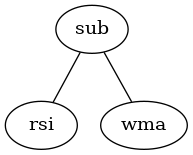

In [17]:
from IPython.display import Image
Image(filename='data/expr_tree.png')

Imprime a expressão simplificada:

In [18]:
print('Expressão final simplificada:', simplified_best)

Expressão final simplificada: rsi - wma


Matriz confusão

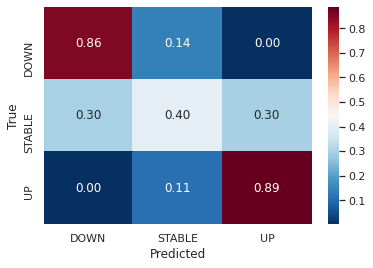

In [19]:
plot_cm(predict(best, X_test), y_test)